# One Shot Learning with Siamese Networks



## Imports
All the imports are defined here

In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
import time
!pip install pytorch_metric_learning
from pytorch_metric_learning import miners, losses

In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


## Helper functions
Set of helper functions

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class


In [ ]:
class Config():
    training_dir = F"/content/gdrive/My Drive/DTU - Speciale F2020/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/campus2_training/"
    testing_dir = F"/content/gdrive/My Drive/DTU - Speciale F2020/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/campus2_test/"
    train_batch_size = 32
    train_number_epochs = 150

## Custom Dataset Class


In [ ]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        labels = list()
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class

        while True:
            #keep looping till the same class image is found
            img1_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img0_tuple[1]==img1_tuple[1] and img0_tuple[0]!=img1_tuple[0]:
                break

        while True:
            #keep looping till a different class image is found
            
            img2_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img0_tuple[1] !=img2_tuple[1] and img1_tuple[1] !=img2_tuple[1]:
                break
        labels = [img0_tuple[1], img1_tuple[1], img2_tuple[1]]
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img2 = Image.open(img2_tuple[0])
        #img0 = img0.convert("L")
        #img1 = img1.convert("L")
        #img2 = img2.convert("L")

        #print("0:", img0_tuple)
        #print("1:", img1_tuple)
        #print("2:", img2_tuple)
        #print(int(img1_tuple[1]!=img0_tuple[1]))

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
            img2 = PIL.ImageOps.invert(img2)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img0, img1 , img2, labels
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)


class SiameseNetworkDataset_single(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        labels = list()
        img0_tuple = random.choice(self.imageFolderDataset.imgs)


        img0 = Image.open(img0_tuple[0])

        #img0 = img0.convert("L")


        #print("0:", img0_tuple)

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)


        if self.transform is not None:
            img0 = self.transform(img0)


        return img0, img0_tuple[1]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)


class SiameseNetworkDataset_triplet(Dataset):
  
  def __init__(self,imageFolderDataset,transform=None,should_invert=True):
      self.imageFolderDataset = imageFolderDataset    
      self.transform = transform
      self.should_invert = should_invert
      
  def __getitem__(self,index):
      img0_tuple = random.choice(self.imageFolderDataset.imgs)

      if img0_tuple[1] == 0:
        img1_tuple = (F"/content/gdrive/My Drive/DTU - Speciale F2020/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/VIPeR/cam_b/"+ os.path.basename(img0_tuple[0]), img0_tuple[1])
      else:
        img1_tuple = (F"/content/gdrive/My Drive/DTU - Speciale F2020/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/VIPeR/cam_a/"+ os.path.basename(img0_tuple[0]), img0_tuple[1])

      while True:
          #keep looping till a different class image is found
          img2_tuple = random.choice(self.imageFolderDataset.imgs) 
          if img0_tuple[0] !=img2_tuple[0] and img1_tuple[0] !=img2_tuple[0] :
              break

      img0 = Image.open(img0_tuple[0])
      img1 = Image.open(img1_tuple[0])
      img2 = Image.open(img2_tuple[0])
      #img0 = img0.convert("L")
      #img1 = img1.convert("L")
      #img2 = img2.convert("L")
      
      #print("0:", img0_tuple)
      #print("1:", img1_tuple)
      #print("2:", img2_tuple)
      #print(int(img1_tuple[1]!=img0_tuple[1]))

      if self.should_invert:
          img0 = PIL.ImageOps.invert(img0)
          img1 = PIL.ImageOps.invert(img1)
          img2 = PIL.ImageOps.invert(img2)

      if self.transform is not None:
          img0 = self.transform(img0)
          img1 = self.transform(img1)
          img2 = self.transform(img2)

      return img0, img1 , img2
  
  def __len__(self):
      return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [ ]:
folder_dataset_train = dset.ImageFolder(root=Config.training_dir)
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)

In [ ]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                #transforms.RandomAffine((0,0), translate=(0.1,0.1), scale =  (1, 1.2)),
                                transforms.ColorJitter((0.5,2)),
                                transforms.Resize((275,134)),
                                transforms.RandomChoice([transforms.RandomCrop((200,100))
                                                        ,transforms.Resize((200,100))]),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                #transforms.RandomErasing(scale=(0.02, 0.2)),
                                ])

siamese_dataset_train = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train,
                                        transform=transform,
                                        should_invert=False)

siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((200,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

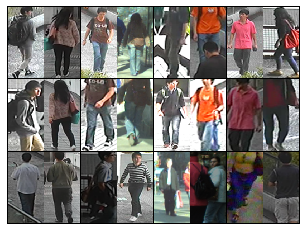

[ 989  254 1553 2438 1331 1721 1882  408]
[ 989  254 1553 2438 1331 1721 1882  408]
[ 975  683 1575   42 2448 2387  484  884]
torch.Size([8, 3, 200, 100])
torch.Size([24, 3, 200, 100])
torch.Size([24])


In [ ]:
vis_dataloader = DataLoader(siamese_dataset_train,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1], example_batch[2]),0)
labels = torch.cat((example_batch[3][0],example_batch[3][1], example_batch[3][0]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[3][0].numpy())
print(example_batch[3][1].numpy())
print(example_batch[3][2].numpy())
print(example_batch[0].shape)
print(concatenated.shape)
print(labels.shape)

## Neural Net Definition


In [ ]:
class TripletNetwork(nn.Module):
    def __init__(self):
        super(TripletNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*200*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output


    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        #return output1, output2
        output3 = self.forward_once(input3)
        return output1, output2, output3

class TripletNetwork_v2(nn.Module):
    def __init__(self):
        super(TripletNetwork_v2, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8 * 100 * 50, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 10))

    def forward(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output


class TripletNetwork_v3(nn.Module):
    def __init__(self):
        super(TripletNetwork_v3, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8 * 100 * 50, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 10))

    def forward(self, input1):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output


## Triplet Loss

In [ ]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

## Test function

In [ ]:
def test(net, dataloader, print_res = True):
  index = 0
  positive = 0
  for i, data in enumerate(test_dataloader,0):
      img0, img1 , img2, labels = data
      x = torch.cat((img0, img1, img2),0)
      x = x.cuda()
      embeddings = net(x)
      
      batch_size = int(embeddings.shape[0]/3)
      euclidean_distance1 = F.pairwise_distance(embeddings[0:batch_size], embeddings[batch_size*1:batch_size*2])
      euclidean_distance2 = F.pairwise_distance(embeddings[0:batch_size], embeddings[batch_size*2:batch_size*3])

      if euclidean_distance1 < euclidean_distance2:
          positive += 1

      index += 1
    
  result =  100*positive/index
  if print_res:
    print("Accruacy:", result, "%")

  return result


## Training Time!

In [ ]:
train_dataloader = DataLoader(siamese_dataset_train,
                        shuffle=True,
                        num_workers=32,
                        batch_size=Config.train_batch_size)

test_dataloader = DataLoader(siamese_dataset_test,
                             num_workers=6,
                             batch_size=1,
                             shuffle=True)

In [ ]:
net = TripletNetwork_v2().cuda()
criterion = TripletLoss(10)
optimizer = optim.AdamW(net.parameters(),lr = 0.0001 )
#optimizer = optim.SGD(net.parameters(),lr = 0.0001, weight_decay=5e-4, momentum=0.9, nesterov=True)


miner = miners.BatchHardMiner()
loss_func = losses.TripletMarginLoss(margin=10)

In [ ]:
counter = []
loss_history = []
counter_hard = []
loss_hard_history = []
accruacy_history = []
iteration_number= 0

timestamp = time.strftime('%b_%d_%Y_%H%M', time.localtime())
BACKUP_NAME = ("TripletHardNet_" + timestamp + ".pt")
torch.save(net, F"/content/gdrive/My Drive/DTU - Speciale F2020/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/models/" + BACKUP_NAME)
print("Networked saved")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TripletNetwork_v2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Networked saved


In [ ]:
HardMining = False
for epoch in range(0,Config.train_number_epochs):
    accruacy_history.append(test(net,test_dataloader))
    for i, data in enumerate(train_dataloader,0):

        optimizer.zero_grad()
        img0, img1 , img2, labels = data
        x = torch.cat((img0, img1, img2),0)
        labels = torch.cat((labels[0], labels[1], labels[2]),0)
        x = x.cuda()
        embeddings = net(x)
        if HardMining or epoch > 100:
          hard_pairs = miner(embeddings, labels)
          loss = loss_func(embeddings, labels, hard_pairs)

        else:
          batch_size = int(embeddings.shape[0]/3)
          loss = criterion(embeddings[0:batch_size],
                           embeddings[batch_size:batch_size*2], 
                           embeddings[batch_size*2:batch_size*3])

        
        HardMining = not HardMining

        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()

        if i %10 == 0:
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss.item()))
            iteration_number +=10
            if HardMining:
              counter.append(iteration_number)
              loss_history.append(loss.item())
            else:
              counter_hard.append(iteration_number)
              loss_hard_history.append(loss.item())

    if epoch %10 == 0:
      torch.save(net, F"/content/gdrive/My Drive/DTU - Speciale F2020/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/models/" + BACKUP_NAME)
      print("Networked saved")

# Plot learning curves
plt.figure(1)
durations_t = torch.tensor(loss_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means.numpy())



Accruacy: 57.802625182304325 %
Epoch number 0
 Current loss 9.988865852355957

Epoch number 0
 Current loss 7.471524238586426

Epoch number 0
 Current loss 6.800652027130127

Epoch number 0
 Current loss 4.066127300262451

Epoch number 0
 Current loss 5.022561550140381

Epoch number 0
 Current loss 2.5174872875213623

Epoch number 0
 Current loss 1.8647931814193726

Epoch number 0
 Current loss 1.9655221700668335

Epoch number 0
 Current loss 3.6894302368164062

Epoch number 0
 Current loss 2.490795612335205

Epoch number 0
 Current loss 1.7356913089752197

Epoch number 0
 Current loss 3.6495113372802734

Epoch number 0
 Current loss 4.847370147705078

Epoch number 0
 Current loss 3.8100149631500244

Epoch number 0
 Current loss 1.7111847400665283

Epoch number 0
 Current loss 1.364601969718933

Epoch number 0
 Current loss 3.7482399940490723

Epoch number 0
 Current loss 2.75199294090271

Epoch number 0
 Current loss 3.493529796600342

Epoch number 0
 Current loss 0.9215149283409119



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type TripletNetwork_v2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Networked saved
Accruacy: 87.16577540106952 %
Epoch number 1
 Current loss 10.343746185302734

Epoch number 1
 Current loss 10.374213218688965

Epoch number 1
 Current loss 10.28919792175293

Epoch number 1
 Current loss 10.265283584594727

Epoch number 1
 Current loss 10.323871612548828

Epoch number 1
 Current loss 10.335832595825195

Epoch number 1
 Current loss 10.374748229980469

Epoch number 1
 Current loss 10.249503135681152

Epoch number 1
 Current loss 10.320093154907227

Epoch number 1
 Current loss 10.284690856933594

Epoch number 1
 Current loss 10.283550262451172

Epoch number 1
 Current loss 10.259122848510742

Epoch number 1
 Current loss 10.315319061279297

Epoch number 1
 Current loss 10.30002498626709

Epoch number 1
 Current loss 10.316239356994629

Epoch number 1
 Current loss 10.282241821289062

Epoch number 1
 Current loss 10.326445579528809

Epoch number 1
 Current loss 10.28146743774414

Epoch number 1
 Current loss 10.337977409362793

Epoch number 1
 Current lo

KeyboardInterrupt: ignored

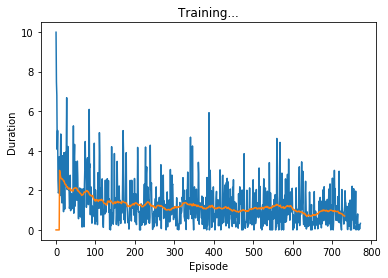

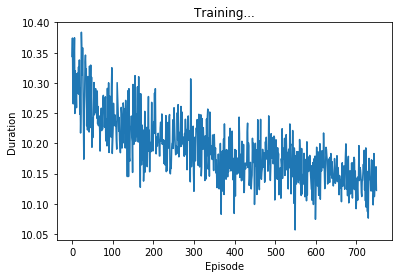

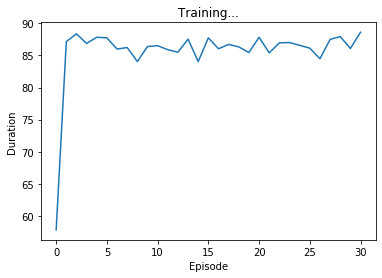

In [ ]:
#Plot 
plt.figure(1)
durations_t = torch.tensor(loss_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means.numpy())

plt.figure(2)
durations_t = torch.tensor(loss_hard_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    #plt.plot(means.numpy())

plt.figure(3)
durations_t = torch.tensor(accruacy_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    #plt.plot(means.numpy())

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

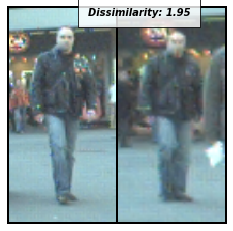

True


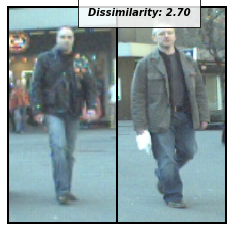

False


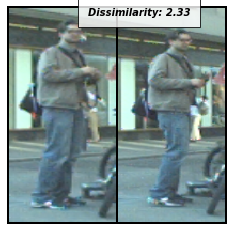

True


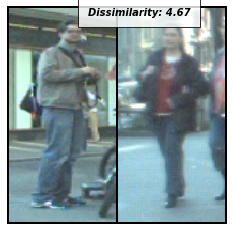

False


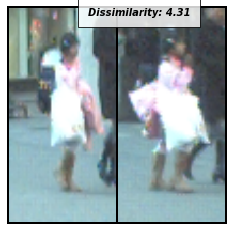

True


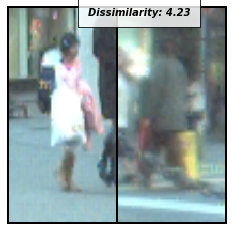

False


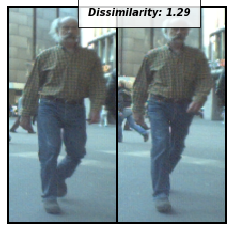

True


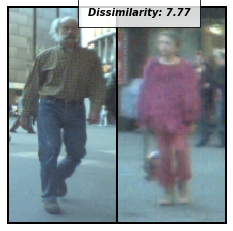

False


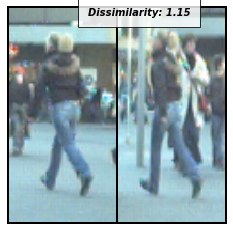

True


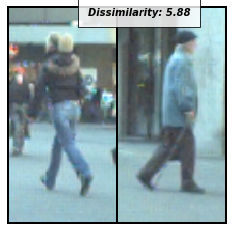

False


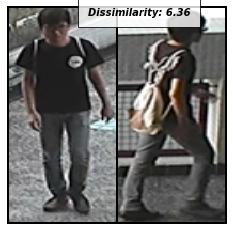

True


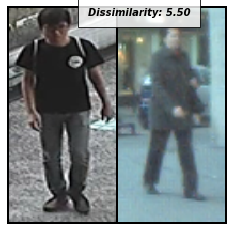

False


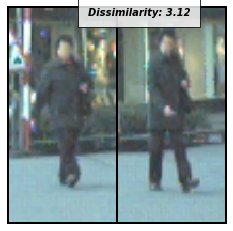

True


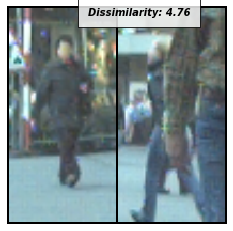

False


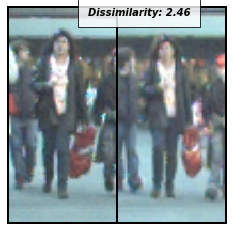

True


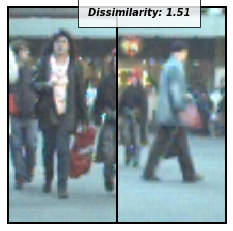

False


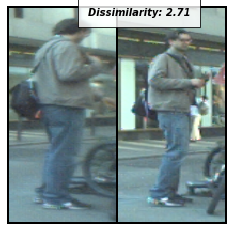

True


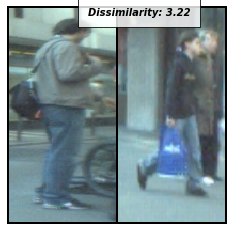

False


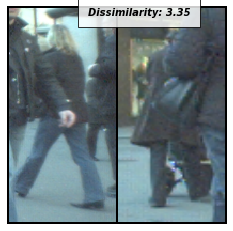

True


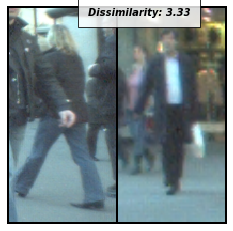

False


In [ ]:
test_dataloader = DataLoader(siamese_dataset_test, num_workers=6, batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_,_ = next(dataiter)

for i in range(10):
    x0,x1,x2,_ = next(dataiter)
    output1,output2, output3 = net(Variable(x0).cuda(),Variable(x1).cuda(),Variable(x2).cuda())
    
    concatenated = torch.cat((x0,x1),0)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    print(True)
    concatenated = torch.cat((x0,x2),0)
    euclidean_distance = F.pairwise_distance(output1, output3)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    print(False)




In [ ]:
#Test code
positive = 0
total = 1000
for i in range(total):
    x0,x1,x2 = next(dataiter)
    output1,output2, output3 = net(Variable(x0).cuda(),Variable(x1).cuda(),Variable(x2).cuda())
    
    concatenated = torch.cat((x0,x1),0)
    euclidean_distance1 = F.pairwise_distance(output1, output2)

    concatenated = torch.cat((x0,x2),0)
    euclidean_distance2 = F.pairwise_distance(output1, output3)

    if euclidean_distance1 < euclidean_distance2:
        positive += 1

print("Got an accruacy of", 100*positive/1000 + "%")




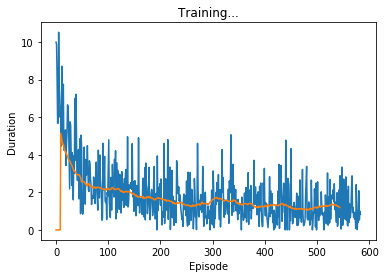

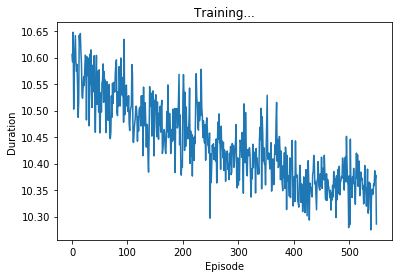

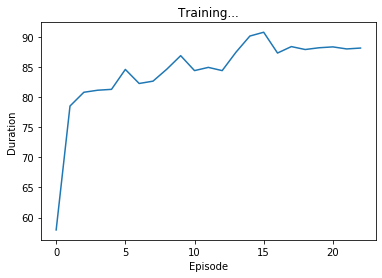

In [ ]:
# Plot learning curves
plt.figure(1)
durations_t = torch.tensor(loss_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means.numpy())

plt.figure(2)
durations_t = torch.tensor(loss_hard_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    #plt.plot(means.numpy())

plt.figure(3)
durations_t = torch.tensor(accruacy_history, dtype=torch.float)
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(durations_t.numpy())
# Take 100 episode averages and plot them too
if len(durations_t) >= 50:
    means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(9), means))
    plt.plot(means.numpy())